In [80]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
%matplotlib inline

path = '/Users/chris/Desktop/mastrangelo/'


In [81]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

In [82]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

Read in and process data (pad and create zero bins)

In [83]:
truth = pd.read_csv(path+'collect_ground_truth.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.read_csv(path+'collect_recovery.csv', converters=dict(transit_multiplicities=literal_eval))


In [ ]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

In [ ]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


Prepare machinery for injection-recovery experiments

In [ ]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-2,0,11)[gi_m] 
    cube[1] = np.linspace(0,1,3)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [ ]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

What would it look like to take the logL of something that's sqrt(N) deviated from the ground truth, where N is the number of systems in each bin? 

Answer: this is $\Delta$ logL of 3 different from the perfect case of comparing the ground truth to itself.

In [ ]:
better_loglike(np.array([9900, 804, 122, 32, 11, 3, 0]), np.array([1e4, 833, 134, 38, 15, 5, 0]))

#### Model 2: m = -1, b = 0.5, c = 4e9, f = 0.3 (average model)

In [316]:
tm_fiducial = truth.loc[(truth.ms == -1) & (truth.bs == 0.5) & (np.round(truth.cs, -9) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities


In [317]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(11):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()

                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # get best logL for each model
                    best_logL = np.max(logLs)

                    all_logLs.append(best_logL)
                except:
                    all_logLs.append(0.)
                

In [318]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})
model_logLs

,m,b,c,f,logL
0,-2.0,0.5,1.000000e+08,0.1,-387.045691
1,-2.0,0.5,1.000000e+08,0.1,-387.045691
2,-2.0,0.5,1.000000e+08,0.1,-387.045691
3,-2.0,0.5,1.000000e+08,0.2,-72.945311
4,-2.0,0.5,1.000000e+08,0.2,-72.945311
...,...,...,...,...,...
12095,0.0,1.0,1.000000e+10,0.9,0.000000
12096,0.0,1.0,1.000000e+10,0.9,0.000000
12097,0.0,1.0,1.000000e+10,1.0,0.000000
12098,0.0,1.0,1.000000e+10,1.0,0.000000


### Note that while these logLs take f into account, they do not take the zero-bin into account. analyze.ipynb has machinery to handle that, and we can do this injection-recovery routine with those logLs instead, if we want. 

#### What is the $\Delta$ logL between the very best model and the ground truth?

Identify best and good models

In [319]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", 
      ground_truth.logL)
delta_logL = best_logL - model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)].logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f       logL
5359 -1.2  1.0  3.981072e+09  0.3 -21.804649
5360 -1.2  1.0  3.981072e+09  0.3 -21.804649
5361 -1.2  1.0  3.981072e+09  0.3 -21.804649
5362 -1.2  1.0  3.981072e+09  0.3 -21.804649
5363 -1.2  1.0  3.981072e+09  0.3 -21.804649
Ground truth:  5909   -21.917619
5910   -21.917619
5911   -21.917619
5912   -21.917619
5913   -21.917619
Name: logL, dtype: float64
Some models between best model and ground truth: 
       m    b             c    f       logL
959 -2.0  1.0  3.981072e+09  0.3 -21.852544
960 -2.0  1.0  3.981072e+09  0.3 -21.852544
961 -2.0  1.0  3.981072e+09  0.3 -21.852544
962 -2.0  1.0  3.981072e+09  0.3 -21.852544
963 -2.0  1.0  3.981072e+09  0.3 -21.852544


Plot these models

In [17]:
def build_models(x, m, b, c, f): # adapted from Ballard et al in prep, log version
    """ 
    Calculate P(intact) as a function of time, in order to visualize sculpting models.

    Input:
    - x: grid of ages [log yrs]
    - m: sculpting law slope [dex]
    - b: sculpting law initial intact probability, out of planet-hosting stars
    - c: sculpting law turnoff time [log yrs]
    - f: fraction of planet-hosting stars

    Output:
    - y: grid of P(intacts)

    """

    # x-axis before cutoff
    x1 = x[x<c]
    x2 = x[x>=c]
    
    # first piece, before cutoff
    y1 = (b + m * (np.log10(x1) - 8)) * f
    
    # second piece, after cutoff
    y2 = np.ones(len(x2)) * (b + m * (np.log10(c) - 8)) * f
    
    y = np.concatenate((y1, y2))
    
    # flatten out at zero
    y = np.where(y < 0, 0, y)
    
    return y

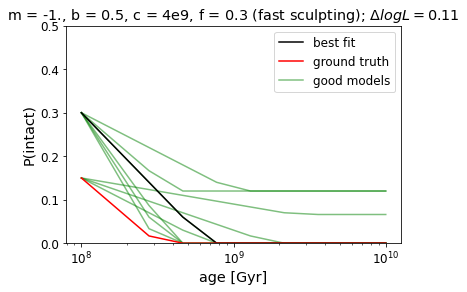

In [320]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

#### Normalizing no-sculpting models, which are fewer than the others

In [199]:
model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.f == 0.1)]

,m,b,c,f,logL
11000,0.0,0.5,1.000000e+08,0.1,-397.434609
11001,0.0,0.5,1.000000e+08,0.1,-397.434609
11002,0.0,0.5,1.000000e+08,0.1,-397.434609
11050,0.0,0.5,1.584893e+08,0.1,-391.523303
11051,0.0,0.5,1.584893e+08,0.1,-391.523303
...,...,...,...,...,...
12001,0.0,1.0,6.309573e+09,0.1,0.000000
12002,0.0,1.0,6.309573e+09,0.1,0.000000
12050,0.0,1.0,1.000000e+10,0.1,0.000000
12051,0.0,1.0,1.000000e+10,0.1,0.000000


Ope! Looks like I've lost a few differing cutoff timescale files for the case of no sculpting. Fortunately, this edge case means that the logL should be the same regardless of cutoff time. 

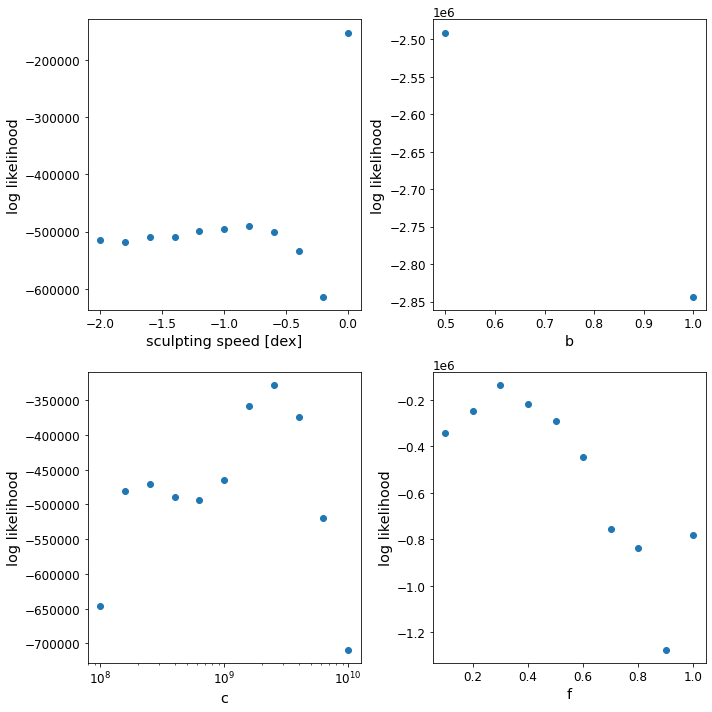

In [189]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(2):
    gi_b = gi_b + 1
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

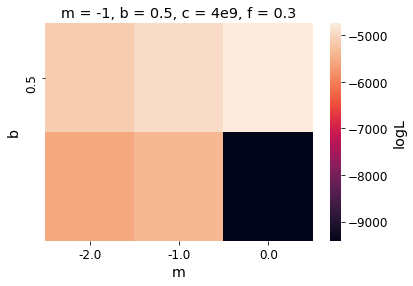

In [37]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

In [38]:
piv

m,-2.0,-1.0,0.0
b,,,
0.5,-5107.525974,-4927.432818,-4741.833165
1.0,-5532.992445,-5376.890655,-9413.281619


In [35]:
model_logLs.loc[model_logLs.f == 0.3].groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL')

c    f         logL
m    b                                  
-2.0 0.5  2.692617e+10  3.3 -2039.354036
     1.0  2.692617e+10  3.3 -1756.797015
-1.0 0.5  2.692617e+10  3.3 -1696.260358
     1.0  2.692617e+10  3.3 -1047.170804
 0.0 0.5  2.692617e+10  3.3  -292.472633
     1.0  2.692617e+10  3.3 -1615.694456

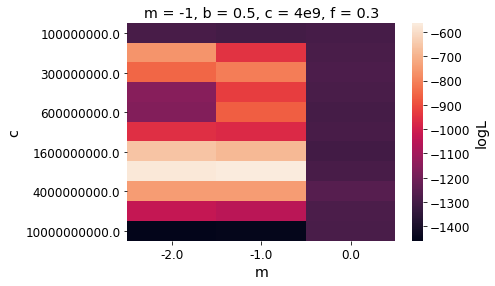

In [55]:
piv = model_logLs.groupby(['m','b','c']).memlsan('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(-8), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

It looks like we recover a cutoff time of 2.5 Gyrs instead of 4 Gyrs, as well as {m=0, b=0.5} instead of {m=-1, b=0.5}, although the latter is a close one, and in general the 1D posteriors show that m=0 is generally bad.

#### Model 3: m = -2, b = 1.0, c = 1e9, f = 0.3 (fast sculpting)


In [29]:
tm_fiducial = truth.loc[(truth.ms == -2) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities


In [54]:
tm_fiducial[192]

[66708.6, 630.9, 38.4, 1.2, 0.3, 0.6, 0.0]

In [56]:
test_recovery = recovery.loc[(recovery.ms == -1) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities

In [59]:
test_recovery.head()

41470    [66720.6, 618.9, 37.8, 1.7999999999999998, 0.6...
41471           [66738.6, 603.0, 35.4, 2.1, 0.6, 0.3, 0.0]
41472    [66717.9, 619.5, 38.699999999999996, 2.1, 1.2,...
41473    [66691.2, 646.1999999999999, 39.9, 1.5, 0.8999...
41474    [66707.7, 631.5, 36.6, 2.4, 1.7999999999999998...
Name: transit_multiplicities, dtype: object

In [58]:
better_loglike(test_recovery[41470], tm_fiducial[192])

-16.228641136962352

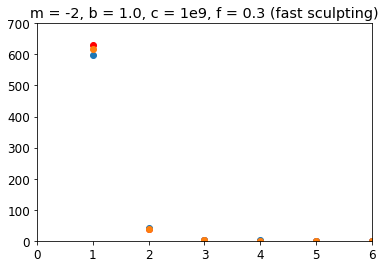

In [79]:
plt.scatter(np.arange(len(tm_fiducial[192])), tm_fiducial[192], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[41470].transit_multiplicities)), recovery.iloc[41470].transit_multiplicities, label='recovery different')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -2, b = 1.0, c = 1e9, f = 0.3 (fast sculpting)')
plt.show()

In [30]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(11):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()

                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # get best logL for each model
                    best_logL = np.max(logLs)

                    all_logLs.append(best_logL)
                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})
        

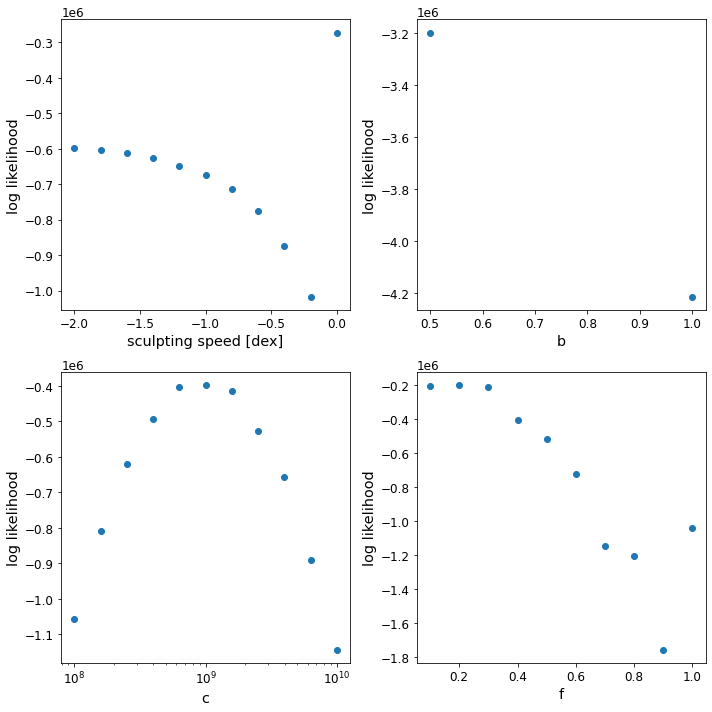

In [31]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(2):
    gi_b = gi_b + 1
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

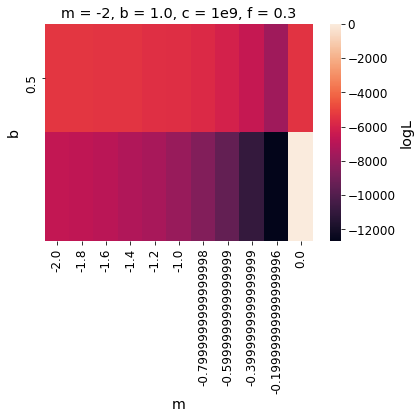

In [32]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -2, b = 1.0, c = 1e9, f = 0.3')
plt.show()

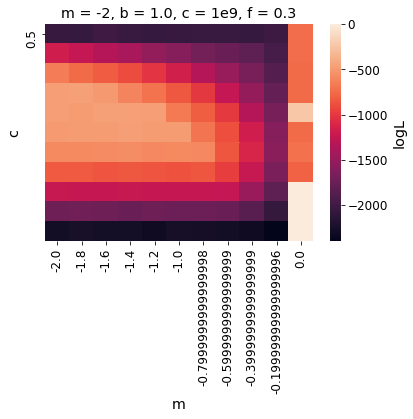

In [33]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -2, b = 1.0, c = 1e9, f = 0.3')
plt.show()

1D posteriors show that I can recover m and c, but not quite f and definitely not b. 2D posteriors corroborate this for m and b, and they suggest that there are fast sculpting models with even shorter cutoff times that are also favored. 

Identify best and good models

In [38]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -2.) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.logL)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f      logL
4559 -1.2  0.5  398107171.0  0.3 -13.24083
4560 -1.2  0.5  398107171.0  0.3 -13.24083
4561 -1.2  0.5  398107171.0  0.3 -13.24083
4562 -1.2  0.5  398107171.0  0.3 -13.24083
4563 -1.2  0.5  398107171.0  0.3 -13.24083
Ground truth:  809   -14.937079
810   -14.937079
811   -14.937079
812   -14.937079
813   -14.937079
Name: logL, dtype: float64
Some models between best model and ground truth: 
       m    b            c    f       logL
109 -2.0  0.5  251188643.0  0.3 -13.269142
110 -2.0  0.5  251188643.0  0.3 -13.269142
111 -2.0  0.5  251188643.0  0.3 -13.269142
112 -2.0  0.5  251188643.0  0.3 -13.269142
113 -2.0  0.5  251188643.0  0.3 -13.269142


Plot these models

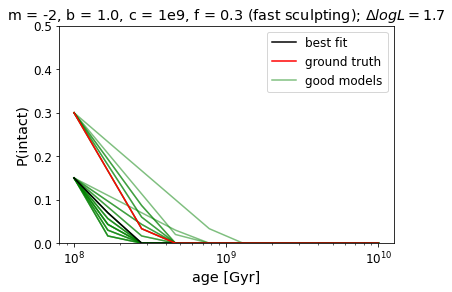

In [39]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -2, b = 1.0, c = 1e9, f = 0.3 (fast sculpting); $\Delta logL = {np.round(delta_logL, 2)}$')
plt.legend()
plt.show()

Also, plot their transit multiplicity yields

In [42]:
print(tm_fiducial)
print(truth.loc[(truth.ms == -2) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)])
print(recovery.loc[(recovery.ms == -2) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)])

192    [66708.6, 630.9, 38.4, 1.2, 0.3, 0.6, 0.0]
Name: transit_multiplicities, dtype: object
      ms   bs            cs   fs                      transit_multiplicities  \
192 -2.0  1.0  1.000000e+09  0.3  [66708.6, 630.9, 38.4, 1.2, 0.3, 0.6, 0.0]   

                         geom_transit_multiplicities  intact_fracs  \
192  [1245.8999999999999, 140.1, 8.1, 6.6, 4.8, 1.2]      0.018815   

     disrupted_fracs       logLs               transit_multiplicity_zero_bin  
192         0.281185 -260.340596  [66708.6, 630.9, 38.4, 1.2, 0.3, 0.6, 0.0]  
       ms   bs            cs   fs  \
5470 -2.0  1.0  1.000000e+09  0.3   
5471 -2.0  1.0  1.000000e+09  0.3   
5472 -2.0  1.0  1.000000e+09  0.3   
5473 -2.0  1.0  1.000000e+09  0.3   
5474 -2.0  1.0  1.000000e+09  0.3   
5475 -2.0  1.0  1.000000e+09  0.3   
5476 -2.0  1.0  1.000000e+09  0.3   
5477 -2.0  1.0  1.000000e+09  0.3   
5478 -2.0  1.0  1.000000e+09  0.3   
5479 -2.0  1.0  1.000000e+09  0.3   
5480 -2.0  1.0  1.000000e+09  0.3   
54

In [40]:
ground_truth

,m,b,c,f,logL
809,-2.0,1.0,1.000000e+09,0.3,-14.937079
810,-2.0,1.0,1.000000e+09,0.3,-14.937079
811,-2.0,1.0,1.000000e+09,0.3,-14.937079
812,-2.0,1.0,1.000000e+09,0.3,-14.937079
813,-2.0,1.0,1.000000e+09,0.3,-14.937079


#### Model 4: m = 0, b = 0.5, c = 1e9, f = 0.3 (no sculpting)


In [322]:
tm_fiducial = truth.loc[(truth.ms == 0.) & (truth.bs == 0.5) & (np.round(truth.cs, -9) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities


In [323]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(11):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()

                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # get best logL for each model
                    best_logL = np.max(logLs)

                    all_logLs.append(best_logL)
                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})
        

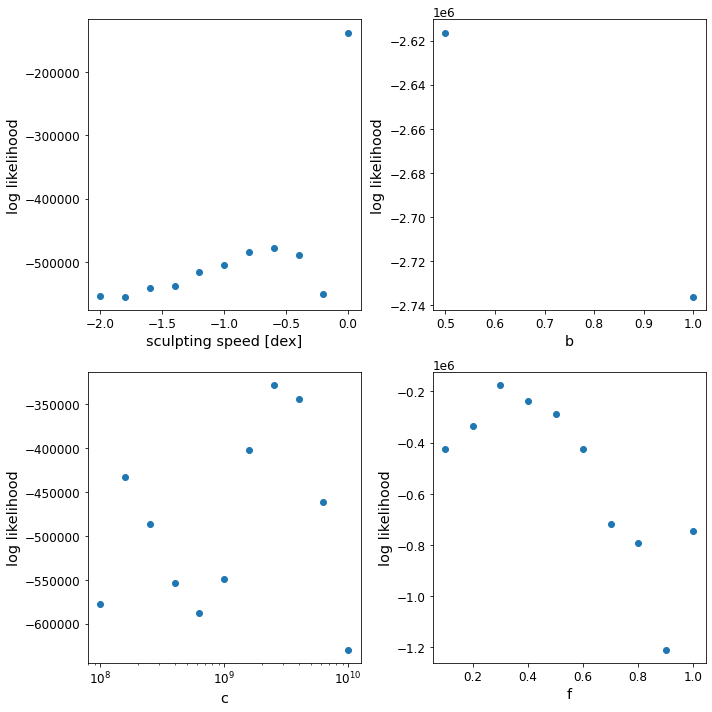

In [324]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(2):
    gi_b = gi_b + 1
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

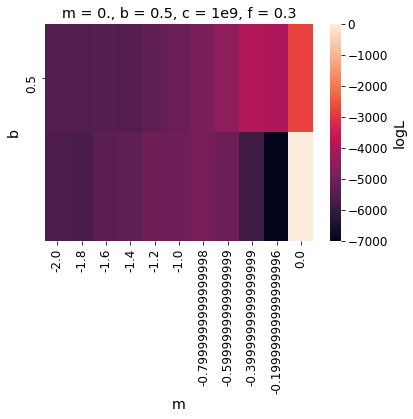

In [325]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3')
plt.show()

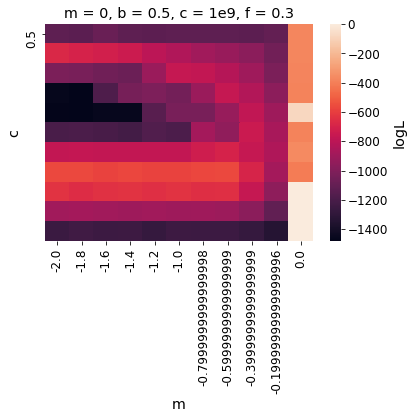

In [326]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0, b = 0.5, c = 1e9, f = 0.3')
plt.show()

We totally miss the mark on recovering the lack of sculpting in the fake ground truth. We do recover b and f, and of course c is not a sensible variable in the case of no sculpting. 

Identify best and good models

In [330]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.logL)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:           m    b             c    f       logL
10309 -0.2  0.5  3.981072e+09  0.3 -22.273353
10310 -0.2  0.5  3.981072e+09  0.3 -22.273353
10311 -0.2  0.5  3.981072e+09  0.3 -22.273353
10312 -0.2  0.5  3.981072e+09  0.3 -22.273353
10313 -0.2  0.5  3.981072e+09  0.3 -22.273353
Ground truth:  11209   -22.524196
11210   -22.524196
11211   -22.524196
11212   -22.524196
11213   -22.524196
11259   -22.720030
11260   -22.720030
11261   -22.720030
11262   -22.720030
11263   -22.720030
Name: logL, dtype: float64
Some models between best model and ground truth: 
      m    b            c    f       logL
9  -2.0  0.5  100000000.0  0.3 -22.273827
10 -2.0  0.5  100000000.0  0.3 -22.273827
11 -2.0  0.5  100000000.0  0.3 -22.273827
12 -2.0  0.5  100000000.0  0.3 -22.273827
13 -2.0  0.5  100000000.0  0.3 -22.273827


Plot these models

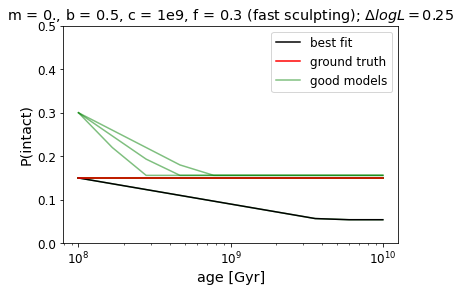

In [331]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = 0., b = 0.5, c = 1e9, f = 0.3 (fast sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()